In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tld
#!pip3 install flair
#!pip install contractions
#!pip install beautifulsoup4
#!pip install bertopic
!pip install nltk

     |████████████████████████████████| 412 kB 14.1 MB/s 


Following function then gives domain name. It takes as an argument an URL and returns the domain name:

In [3]:
from tld import get_tld
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import random
import pandas as pd
import numpy as np
import networkx as nx

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld


Read the Data

In [4]:
import bz2
import json
from nltk.stem.porter import *
stemmer = PorterStemmer()
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk_sentiment = SentimentIntensityAnalyzer()

path_to_file = '/content/drive/MyDrive/quotes-nytimes.json.bz2' #2019
#path_to_out = '/content/quotes-2020-domains.json.bz2'
domains = []
speakers = []
quotation = []
popularity = []
sentiment = []
polarity_neg = []
polarity_pos = []

with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            urls = instance['urls'] # extracting list of links
            popularity.append(len(instance['urls']) - 1)
            domains.append(instance['urls'])
            quotation.append(instance['quotation'])
            speakers.append(instance['speaker'].lower())
            polarity_neg.append(nltk_sentiment.polarity_scores(instance['quotation'])['neg'])
            polarity_pos.append(nltk_sentiment.polarity_scores(instance['quotation'])['pos'])
            

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Extract NYT Links from the domain

In [6]:
from urllib.parse import * 
parse_url = urlparse(domains[1][0])
nyt_urls = []
non_nyt = []
other_urls = []

for domain in domains:
  count = 0
  other_url = []
  for url in domain:
    parsed_url = urlparse(url)
    if parsed_url.netloc == 'www.nytimes.com' or parsed_url.netloc == 'nytimes.com' or parsed_url.netloc == 'mobile.nytimes.com' or parsed_url.netloc == 'feeds.nytimes.com':
      if count == 0:
        nyt_urls.append(parsed_url)
        count = 1  
    else:
      other_url.append(parsed_url.netloc)
  other_urls.append(other_url)
      
  if count == 0:
    nyt_urls.append(urlparse('https://www.nytimes.com/unknown'))
    non_nyt.append(domain)

Extract Topics from NYT Links

In [8]:
topics = []
for url in nyt_urls:
  count = 0
  start = 12
  if url.path[1:] == 'unknown':
    topics.append('unknown')
    continue  
  if url.netloc == 'feeds.nytimes.com':
    start = 24
  if url.path[1:12] == 'interactive':
    start = 24
  if url.path[1:5] == 'live':
    topics.append('live')
    continue  
  
  for letter in url.path[start:]:
    if letter == '/':
      break
    count = count+ 1
  topics.append(url.path[start:][:count])

Create Pandas DataFrame. Contains Topic, Speaker, Quotation which are defined above and popularity which is the number of news outlets that have shared the news item

In [9]:

data = pd.DataFrame(topics, columns =['topic'])
data['speaker'] = speakers
data['quotation'] = quotation
data['popularity'] = popularity
data['polarity_pos'] = polarity_pos 
data['polarity_neg'] = polarity_neg 
data.head()


,topic,speaker,quotation,popularity,polarity_pos,polarity_neg
0,realestate,james fisher,"It is not a low-income immigration,",0,0.000,0.000
1,opinion,john updike,a champion figure skater switching to roller s...,1,0.394,0.000
2,world,none,It makes it much more difficult for him to mak...,0,0.000,0.189
3,technology,xavier becerra,"It puts me in a predicament,",2,0.000,0.000
4,books,none,A Pile of Leaves.,0,0.000,0.000


Plot the counts of the most popular topics published by NYT

In [10]:
top10_topics = data.groupby('topic').count()['speaker'].sort_values(ascending=False)[:10]

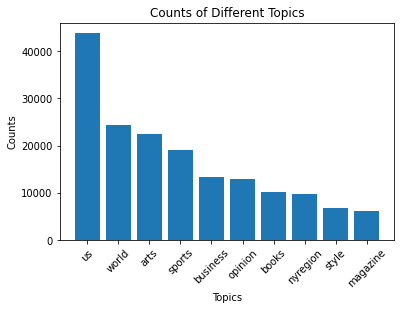

In [11]:
plt.xticks(rotation=45)
plt.bar(list(top10_topics.index), top10_topics.values)
plt.title('Counts of Different Topics')
plt.ylabel('Counts')
plt.xlabel('Topics')
plt.show()

Print the most popular speakers for different topics 

In [14]:
data_filtered = data[data.speaker != 'none']
famous_speaker = data_filtered.groupby(['topic', 'speaker']).count()['popularity']

In [15]:
print("Most Popular Speakers wrt different topics")
famous_speaker.sort_values(ascending=False)[:20]

Most Popular Speakers wrt different topics


topic     speaker               
us        president donald trump    1318
          president trump           1087
          joe biden                  612
          elizabeth warren           583
arts      stephen colbert            445
us        bernie sanders             427
          nancy pelosi               408
          pete buttigieg             397
arts      jimmy kimmel               318
world     president donald trump     288
arts      trevor noah                275
nyregion  bill de blasio             271
opinion   president donald trump     266
us        cory booker                251
arts      seth meyers                246
          jimmy fallon               236
opinion   president trump            232
world     mike pompeo                232
          president trump            209
us        amy klobuchar              205
Name: popularity, dtype: int64

Plot the popularity of the major topics. Popularity is the average number of news outlets that share a particular news item

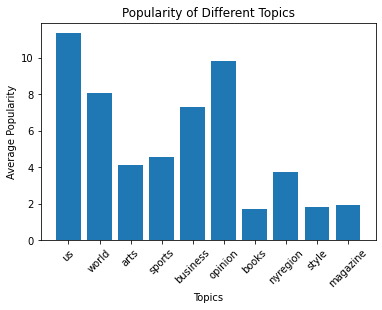

In [16]:
popularity_top10 = data.groupby('topic').mean()['popularity'][top10_topics.index]
plt.xticks(rotation=45)
plt.bar(list(popularity_top10.index), popularity_top10.values)
plt.title('Popularity of Different Topics')
plt.ylabel('Average Popularity')
plt.xlabel('Topics')
plt.show()

Preprocessing for topic wise extraction

In [18]:
a =set(top10_topics.index)
popular_speakers = []
count_speakers = []
from tqdm import tqdm
for topic in tqdm(top10_topics.index):
  data_top10 = data[data.topic == topic]
  index_speaker = data_top10.groupby(['speaker']).count()['quotation'].sort_values(ascending=False)[1:11].index
  count = data_top10.groupby(['speaker']).count()['quotation'].sort_values(ascending=False)[1:11].values
  popular_speakers.append(list(index_speaker))
  count_speakers.append(list(count))


100%|██████████| 10/10 [00:00<00:00, 20.59it/s]


In [44]:
top_speakers = []
count_top_speakers = []
average_popularity = []
average_popularity_top_speakers = []
np_other_urls = np.array(other_urls)

average_polarity_neg = []
average_polarity_pos = []
average_polarity_top_speakers_neg = []
average_polarity_top_speakers_pos = []
corr_coef_neg = []
corr_coef_pos = []
popular_news_vendors = []


for topic in tqdm(top10_topics.index):
  data_topic = data[data.topic == topic]
  common_url = []
  for url in np_other_urls[data.topic == topic]:
    common_url = common_url + url
  popular_news_vendors.append(Counter(common_url).most_common(10))
  other_news_vendor = sum(np_other_urls[data.topic == topic], [])
  popular_news_vendors.append(Counter(other_news_vendor).most_common(10))
  average_popularity.append(data_topic['popularity'].mean())
  average_polarity_neg.append(data_topic['polarity_neg'].mean())
  average_polarity_pos.append(data_topic['polarity_pos'].mean())
  index_speaker = (data_topic.groupby(['speaker']).count()['quotation'].sort_values(ascending=False)[1:10].index)
  top_speakers.append(list(index_speaker))
  average_popularity_top_speakers.append(data_topic[data_topic.speaker.isin(index_speaker)]['popularity'].mean())
  count_top_speakers.append(len(data_topic[data_topic.speaker.isin(index_speaker)]))
  
  average_polarity_top_speakers_pos.append(data_topic[data_topic.speaker.isin(index_speaker)]['polarity_pos'].mean())
  average_polarity_top_speakers_neg.append(data_topic[data_topic.speaker.isin(index_speaker)]['polarity_neg'].mean())

  corr_coef_neg.append(np.corrcoef(data_topic['polarity_neg'].values, data_topic['popularity'].values)[0][1])
  corr_coef_pos.append(np.corrcoef(data_topic['polarity_pos'].values, data_topic['popularity'].values)[0][1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
100%|██████████| 10/10 [06:56<00:00, 41.69s/it]


In [36]:
average_negative_polarity = sum(data['polarity_neg'])/len(data)
average_positive_polarity = sum(data['polarity_pos'])/len(data)

Plot negative vs Positive Polarity 

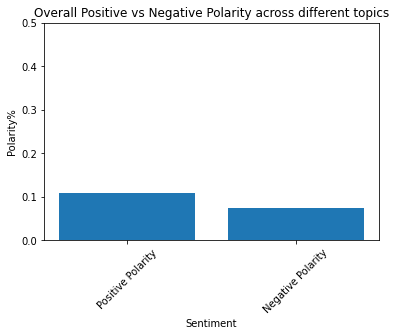

In [43]:
plt.xticks(rotation=45)
plt.bar(["Positive Polarity", "Negative Polarity"], [average_positive_polarity, average_negative_polarity])
plt.title('Overall Positive vs Negative Polarity across different topics')
plt.ylabel('Polarity%')
plt.xlabel('Sentiment')
plt.ylim(0,0.5)
plt.show()

Plot Correlation Coefficients for different topics

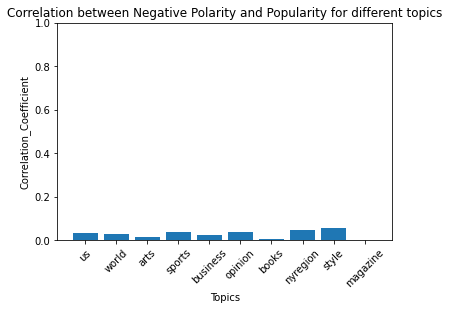

In [21]:
plt.xticks(rotation=45)

plt.bar(list(popularity_top10.index), corr_coef_neg)
plt.title('Correlation between Negative Polarity and Popularity for different topics')
plt.ylabel('Correlation_Coefficient')
plt.xlabel('Topics')
axes = plt.gca()
plt.ylim(0,1)


plt.show()

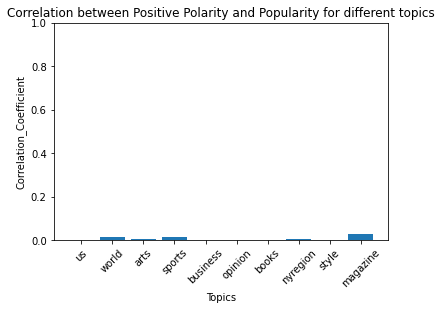

In [22]:
plt.xticks(rotation=45)

plt.bar(list(popularity_top10.index), corr_coef_pos)
plt.title('Correlation between Positive Polarity and Popularity for different topics')
plt.ylabel('Correlation_Coefficient')
plt.xlabel('Topics')

plt.ylim(0,1)


plt.show()

Plot Average Popularity of Articles overall vs the average popularity of top 10 speakers topic wise and plot the percentage of quotes given by top 10 speakers

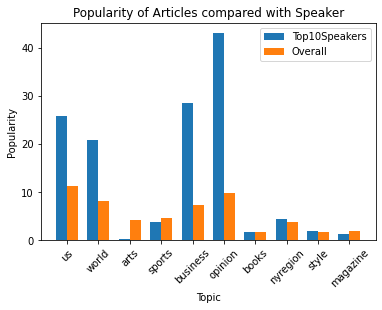

In [24]:



# Generate dummy data into a dataframe

index = np.arange(10)
bar_width = 0.35

fig, ax = plt.subplots()
summer = ax.bar(index, average_popularity_top_speakers, bar_width,
                label="Top10Speakers")

winter = ax.bar(index+bar_width, average_popularity,
                 bar_width, label="Overall")

ax.set_xlabel('Topic')
ax.set_ylabel('Popularity')
ax.set_title('Popularity of Articles compared with Speaker')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list(popularity_top10.index))
ax.legend()
plt.xticks(rotation=45)
plt.show()

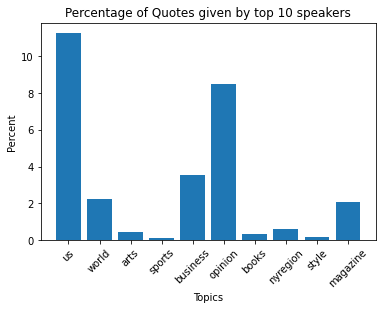

In [ ]:
plt.xticks(rotation=45)
percentage_of_top_speakers = np.array(count_top_speakers[-10:])/top10_topics.values
plt.bar(list(popularity_top10.index), percentage_of_top_speakers*100)
plt.title('Percentage of Quotes given by top 10 speakers')
plt.ylabel('Percent')
plt.xlabel('Topics')
plt.show()

Plots and Experiments for Polarity 

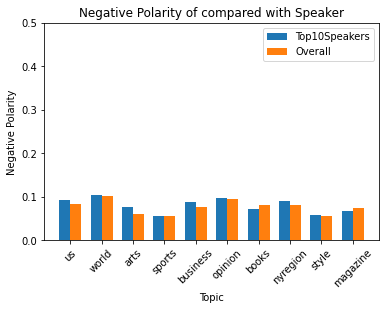

In [25]:


index = np.arange(10)
bar_width = 0.35

fig, ax = plt.subplots()
summer = ax.bar(index, average_polarity_top_speakers_neg, bar_width,
                label="Top10Speakers")

winter = ax.bar(index+bar_width, average_polarity_neg,
                 bar_width, label="Overall")

ax.set_xlabel('Topic')
ax.set_ylabel('Negative Polarity')
ax.set_title('Negative Polarity of compared with Speaker')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list(popularity_top10.index))
ax.legend()
plt.xticks(rotation=45)
plt.ylim(0,0.5)
plt.show()

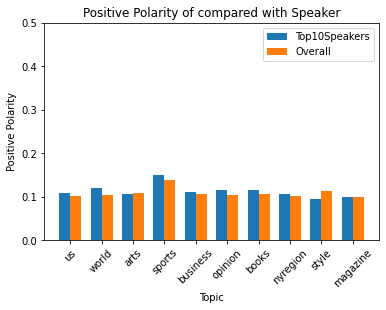

In [26]:

index = np.arange(10)
bar_width = 0.35

fig, ax = plt.subplots()
summer = ax.bar(index, average_polarity_top_speakers_pos, bar_width,
                label="Top10Speakers")

winter = ax.bar(index+bar_width, average_polarity_pos,
                 bar_width, label="Overall")

ax.set_xlabel('Topic')
ax.set_ylabel('Positive Polarity')
ax.set_title('Positive Polarity of compared with Speaker')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list(popularity_top10.index))
ax.legend()
plt.xticks(rotation=45)
plt.ylim(0,0.5)
plt.show()

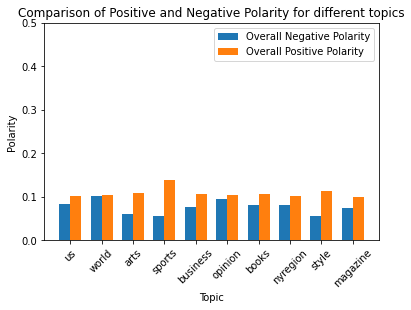

In [29]:

index = np.arange(10)
bar_width = 0.35

fig, ax = plt.subplots()
summer = ax.bar(index, average_polarity_neg, bar_width,
                label="Overall Negative Polarity")

winter = ax.bar(index+bar_width, average_polarity_pos,
                 bar_width, label="Overall Positive Polarity")

ax.set_xlabel('Topic')
ax.set_ylabel('Polarity')
ax.set_title('Comparison of Positive and Negative Polarity for different topics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list(popularity_top10.index))
ax.legend()
plt.xticks(rotation=45)
plt.ylim(0,0.5)
plt.show()

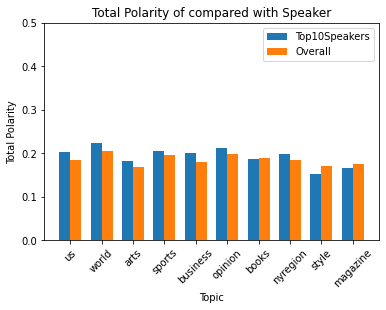

In [30]:
index = np.arange(10)
bar_width = 0.35

fig, ax = plt.subplots()
summer = ax.bar(index, np.array(average_polarity_top_speakers_pos) + np.array(average_polarity_top_speakers_neg), bar_width,
                label="Top10Speakers")

winter = ax.bar(index+bar_width, np.array(average_polarity_pos) + np.array(average_polarity_neg),
                 bar_width, label="Overall")

ax.set_xlabel('Topic')
ax.set_ylabel('Total Polarity')
ax.set_title('Total Polarity of compared with Speaker')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(list(popularity_top10.index))
ax.legend()
plt.xticks(rotation=45)
plt.ylim(0,0.5)
plt.show()

In [ ]:
data_topic = data[data.topic == 'opinion']
neg_pol = data_topic['polarity_neg']
pos_pol = data_topic['polarity_pos']
pop = data_topic['popularity']


Visualization of top speakers and websites associated with New York Times

In [45]:
index_topic = []
for topic in top10_topics.index:
  for i in range(10):
    index_topic.append(topic)

graph_data = pd.DataFrame(index_topic[:60], columns =['topic'])

websites = [[i[0] for i in news_vendor] for news_vendor in popular_news_vendors[:6]]
counts = [[i[1] for i in news_vendor] for news_vendor in popular_news_vendors[:6]]
#data['speaker'] = speakers

In [48]:
graph_data["target"] = (sum(websites,[]))
graph_data['count'] = (sum(counts,[]))
graph_data['speaker'] = (sum(popular_speakers[:6],[]))
graph_data['count_speaker'] = (sum(count_speakers[:6],[]))


In [49]:
G = nx.from_pandas_edgelist(graph_data, source='topic', target = 'target', edge_attr='count')

In [56]:
# Preprocessing for Visualization

set_topics = set(top10_topics.index[:6])
label_dic = {}
website_dic = {}
count = 0
for n in G.nodes():
  if n in set_topics:    
    G.nodes[n]['color'] = 'g'
    label_dic[n] = n
    G.nodes[n]['size'] = 100
  else:
    website_dic[count] = n
    G.nodes[n]['color'] = 'b'
    label_dic[n] = n
    count = count+1
    G.nodes[n]['size'] = 25
d = dict(G.degree)

Visualization of how different websites are associated with NYT. Please follow the visualization given in the data story 

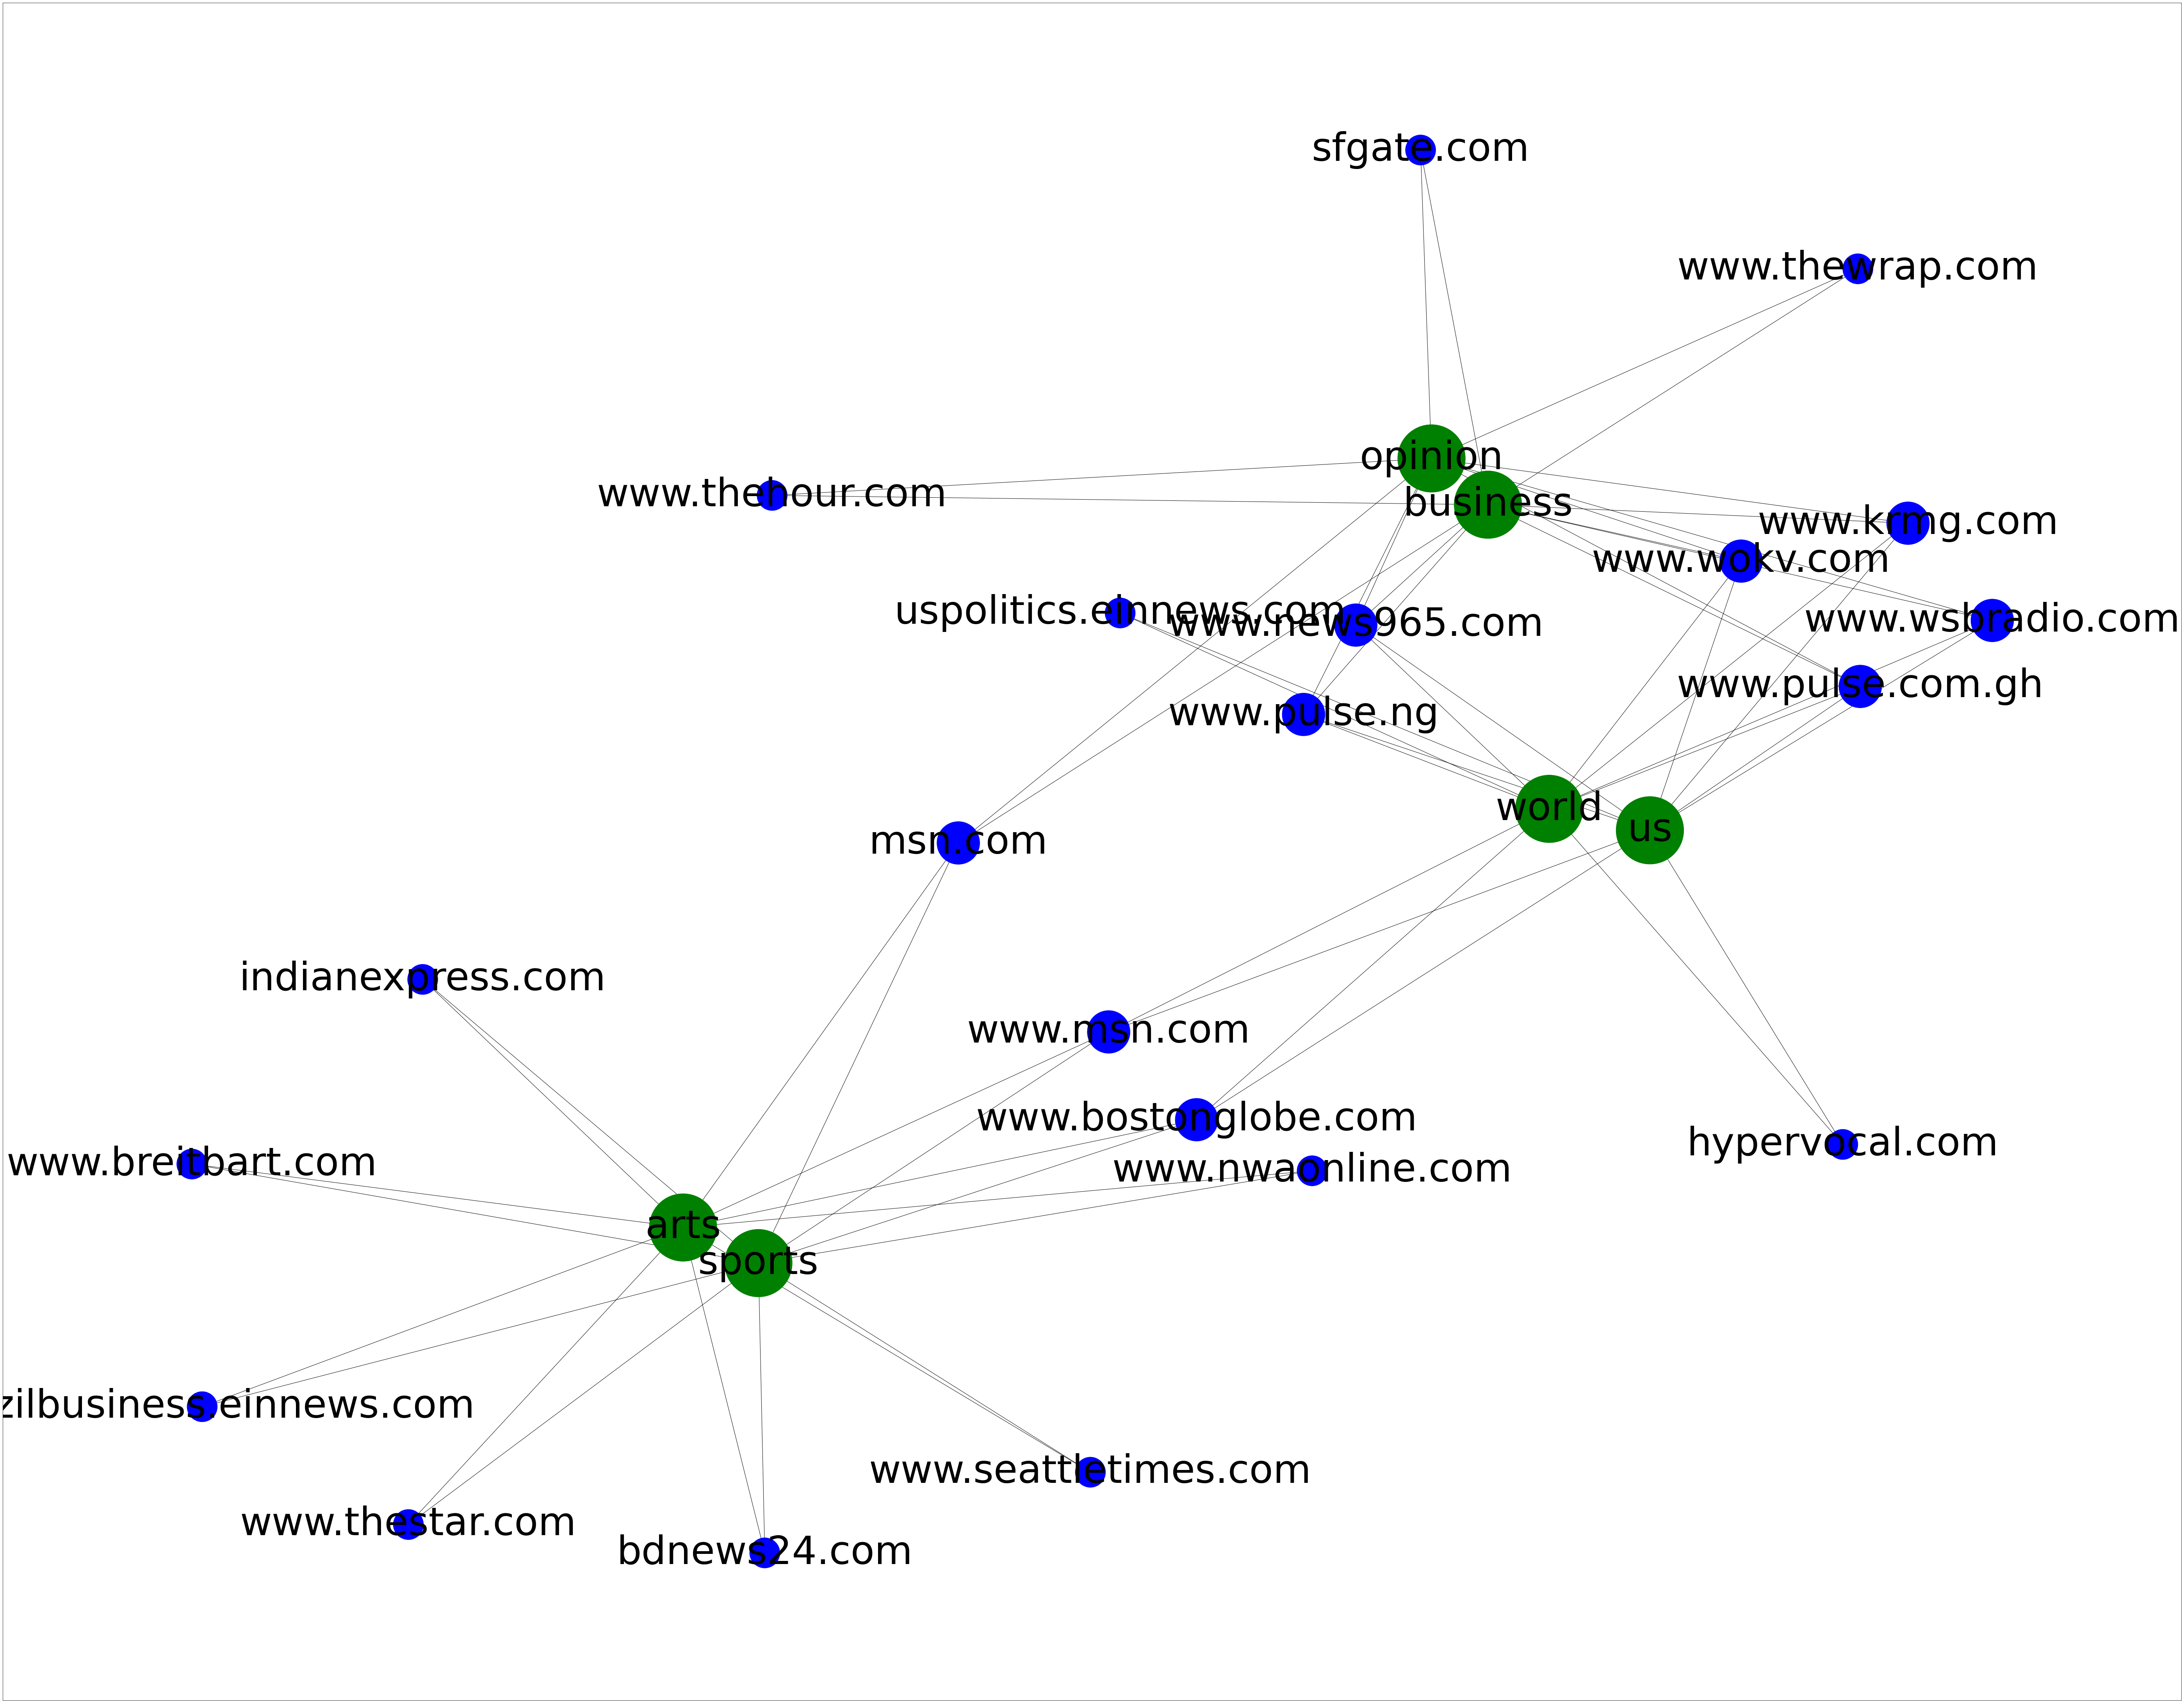

{'us': 'us', 'uspolitics.einnews.com': 'uspolitics.einnews.com', 'www.msn.com': 'www.msn.com', 'www.pulse.com.gh': 'www.pulse.com.gh', 'www.pulse.ng': 'www.pulse.ng', 'www.wokv.com': 'www.wokv.com', 'www.krmg.com': 'www.krmg.com', 'www.news965.com': 'www.news965.com', 'www.wsbradio.com': 'www.wsbradio.com', 'www.bostonglobe.com': 'www.bostonglobe.com', 'hypervocal.com': 'hypervocal.com', 'world': 'world', 'arts': 'arts', 'brazilbusiness.einnews.com': 'brazilbusiness.einnews.com', 'msn.com': 'msn.com', 'bdnews24.com': 'bdnews24.com', 'indianexpress.com': 'indianexpress.com', 'www.breitbart.com': 'www.breitbart.com', 'www.thestar.com': 'www.thestar.com', 'www.seattletimes.com': 'www.seattletimes.com', 'www.nwaonline.com': 'www.nwaonline.com', 'sports': 'sports', 'business': 'business', 'sfgate.com': 'sfgate.com', 'www.thewrap.com': 'www.thewrap.com', 'www.thehour.com': 'www.thehour.com', 'opinion': 'opinion'}


In [73]:

colors = [node[1]['color'] for node in G.nodes(data=True)]
node_size = [node[1]['color']*100 for node in G.nodes(data=True)]
font_size = [node[1]['color']*10 for node in G.nodes(data=True)]
fig = plt.figure(1, figsize=(100, 80))
pos = nx.spring_layout(G, k=0.7, iterations=70)
nx.draw_networkx(G, pos, labels=label_dic, with_labels=True, node_color=colors, font_weight='normal', node_size=[d[k]*3000 for k in d], font_size = 100)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size = 40)
plt.show()
print(label_dic)

Visualization of how different speakers are associated with NYT. Please follow the visualization given in the data story

In [88]:

G = nx.from_pandas_edgelist(graph_data, source='topic', target = 'speaker', edge_attr='count_speaker')

set_topics = set(top10_topics.index[:6])
label_dic = {}
website_dic = {}
count = 0
for n in G.nodes():
  if n in set_topics:    
    G.nodes[n]['color'] = 'g'
    label_dic[n] = n
    G.nodes[n]['size'] = 100
  else:
    website_dic[count] = n
    G.nodes[n]['color'] = 'b'
    G.nodes[n]['size'] = 50
    label_dic[n] = n
    count = count+1

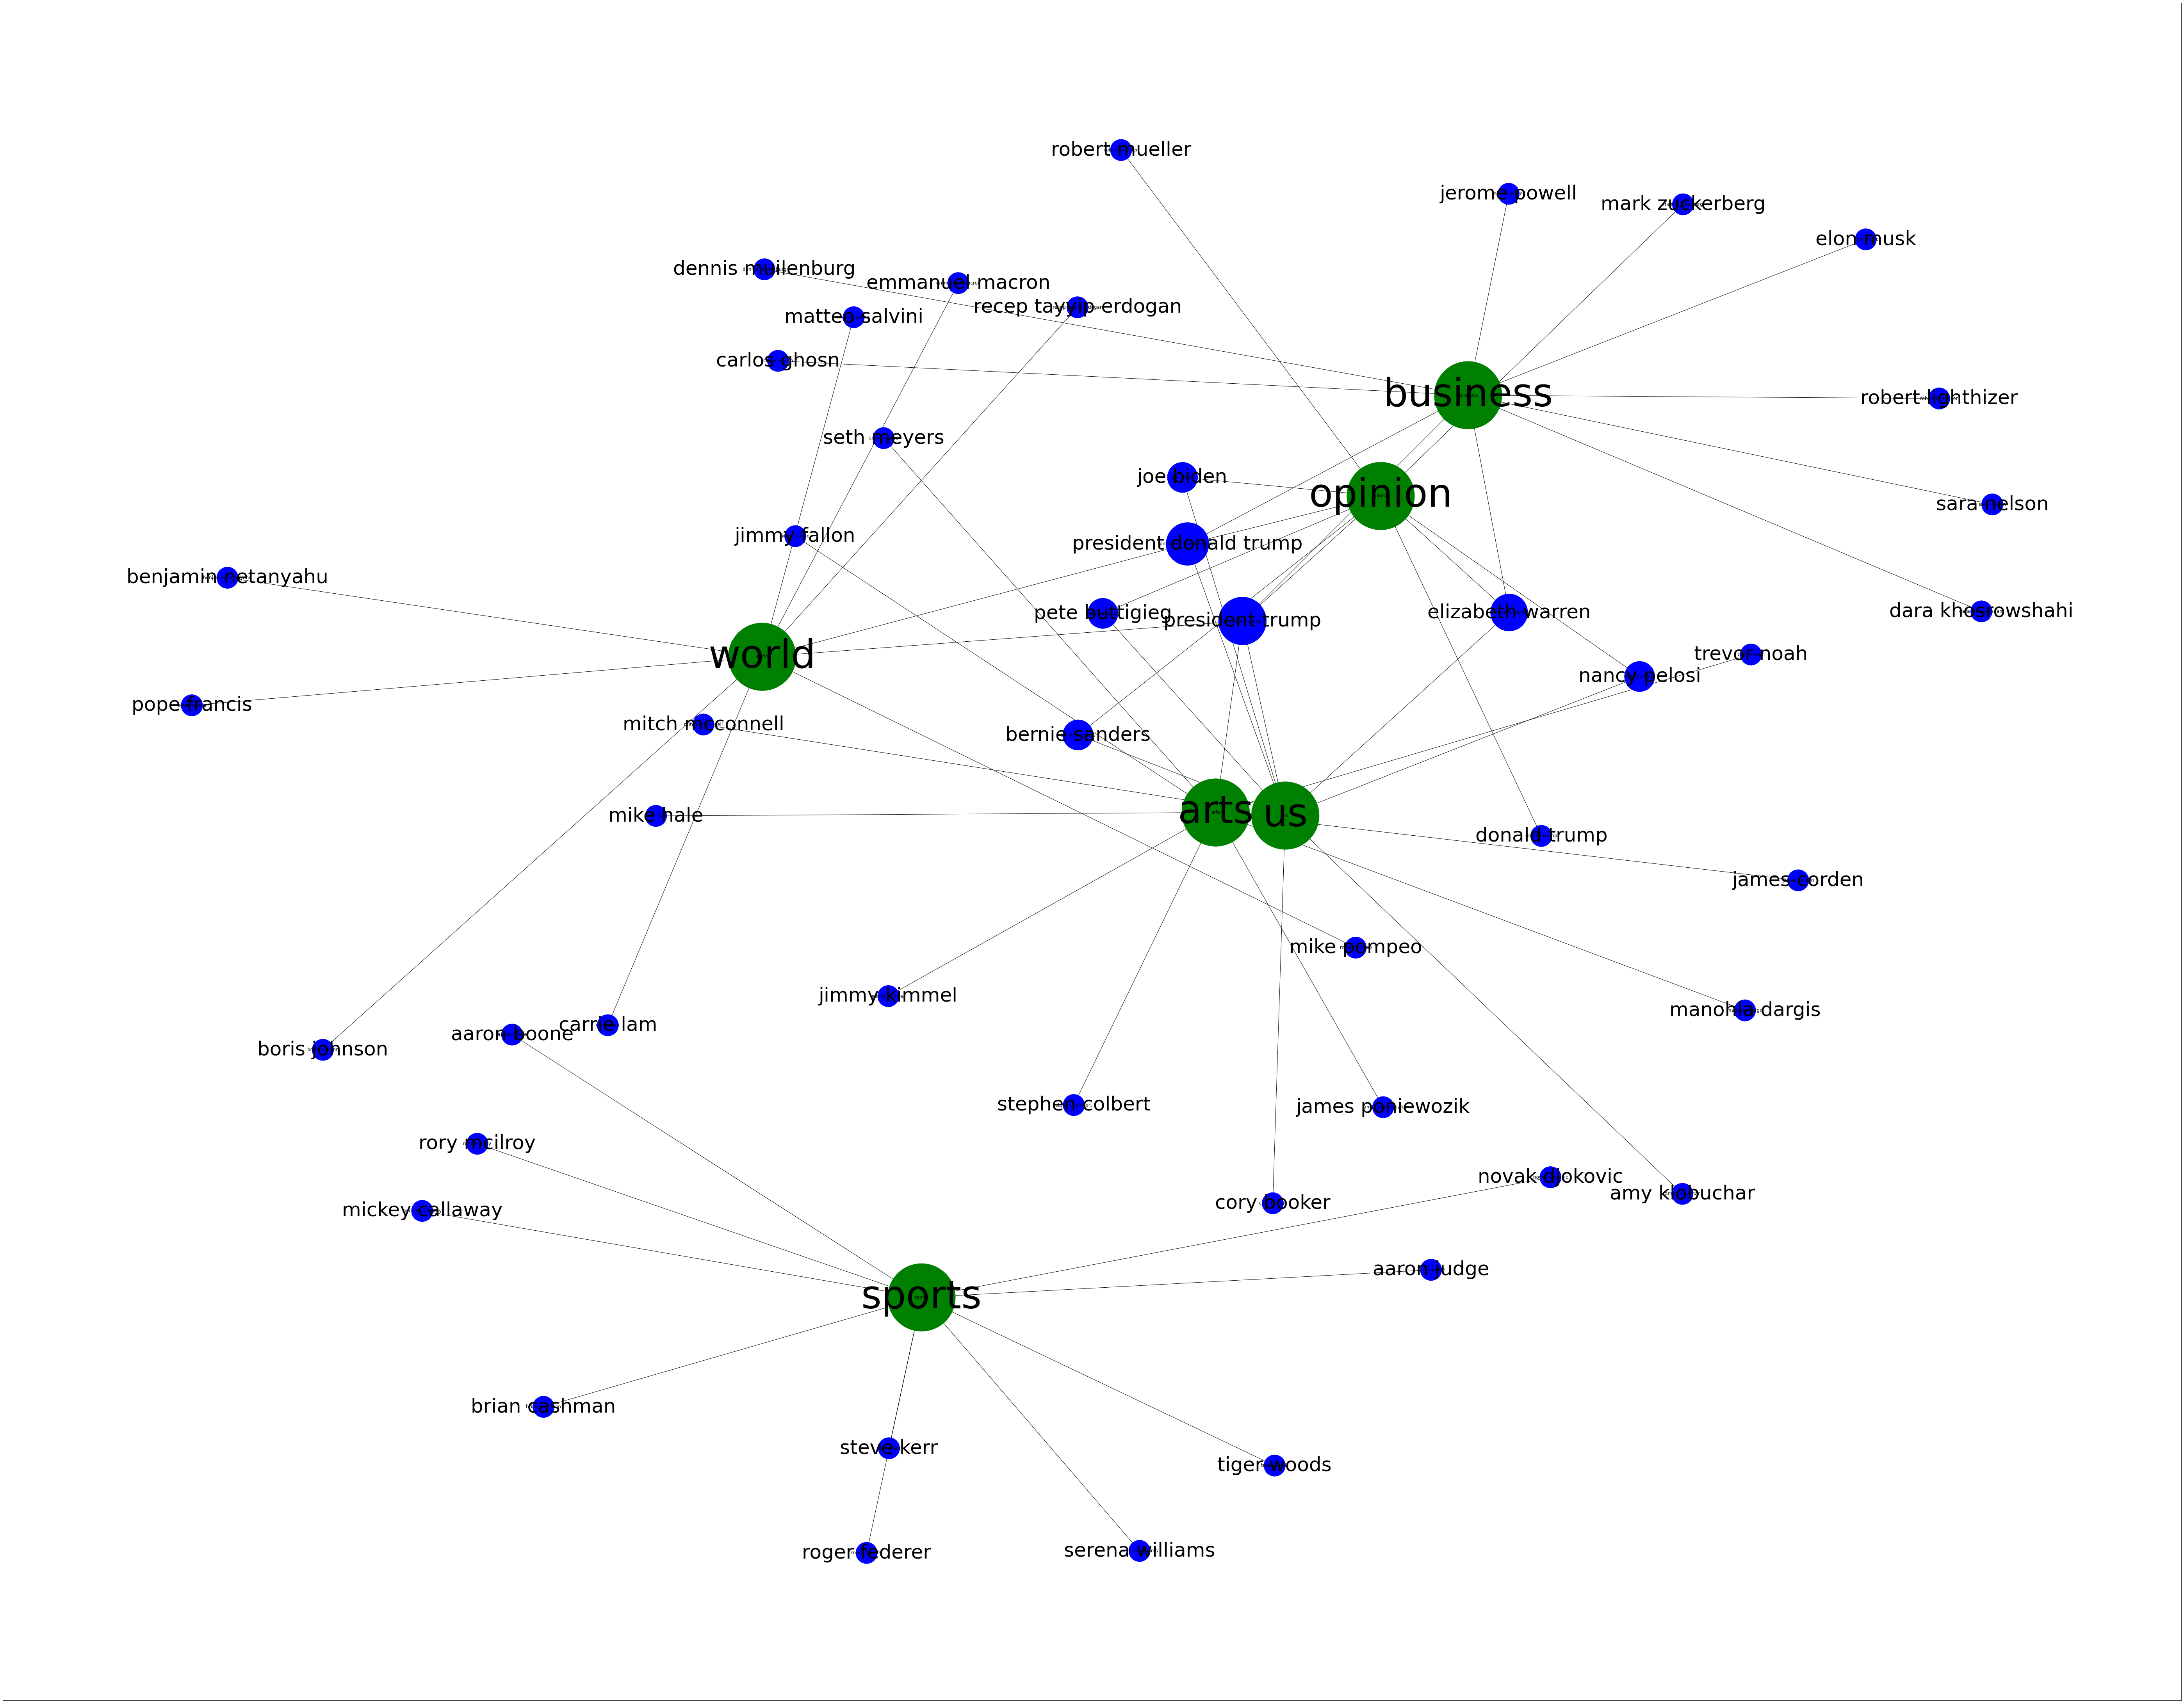

{'us': 'us', 'president donald trump': 'president donald trump', 'president trump': 'president trump', 'joe biden': 'joe biden', 'elizabeth warren': 'elizabeth warren', 'bernie sanders': 'bernie sanders', 'nancy pelosi': 'nancy pelosi', 'pete buttigieg': 'pete buttigieg', 'cory booker': 'cory booker', 'amy klobuchar': 'amy klobuchar', 'mitch mcconnell': 'mitch mcconnell', 'world': 'world', 'mike pompeo': 'mike pompeo', 'emmanuel macron': 'emmanuel macron', 'pope francis': 'pope francis', 'boris johnson': 'boris johnson', 'benjamin netanyahu': 'benjamin netanyahu', 'recep tayyip erdogan': 'recep tayyip erdogan', 'matteo salvini': 'matteo salvini', 'carrie lam': 'carrie lam', 'arts': 'arts', 'stephen colbert': 'stephen colbert', 'jimmy kimmel': 'jimmy kimmel', 'trevor noah': 'trevor noah', 'seth meyers': 'seth meyers', 'jimmy fallon': 'jimmy fallon', 'manohla dargis': 'manohla dargis', 'james corden': 'james corden', 'mike hale': 'mike hale', 'james poniewozik': 'james poniewozik', 'spor

In [99]:
from matplotlib.pyplot import figure, text
colors = [node[1]['color'] for node in G.nodes(data=True)]
fig = plt.figure(1, figsize=(100, 80))
d = dict(G.degree)
pos = nx.spring_layout(G, k=0.4, iterations = 30)
nx.draw_networkx(G, pos, labels=label_dic, with_labels=True, node_color=colors, font_weight='normal', node_size=[d[k]*3000 for k in d])#, font_size = 100)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size = 40)
for node, (x, y) in pos.items():
    text(x, y, node, fontsize=G.nodes[node]['size'], ha='center', va='center')
plt.show()
print(label_dic)